# Group 5: Movie Recommender Challenge: Unsupervised Learning - EDSA

### Drikus Notebook 

![title](resources/imgs/Recommend.png)

## Table of Contents

1. <a href ="#1.-Challenge-Description">Challenge Description</a>
2. <a href ="#2.-Evaluation-Metric">Evaluation Metric</a>
3. <a href ="#3.-Comet-Experiment">Comet Experiment</a>
4. <a href ="#4.-Importing-Libraries">Importing Libraries</a>
5. <a href ="#5.-Importing-Data">Importing Data</a>
6. <a href ="#6.-Data-Description">Data Decription</a>
7. <a href ="#7.-Exploratory-Data-Analysis"> Exploratory Data Analysis</a>
8. <a href ="#8.-Recommendation-System:-Content-Based-Filtering">Recommendation System: Content Based Filtering</a>
9. <a href ="#9.-Dimensionality-Reduction">Dimensionality Reduction</a>
10. <a href ="#10.-Collaborative-Filtering">Collaborative Filtering</a>
11. <a href ="#11.-Conclusion">Conclusion</a>
12. <a href ="#12.-Submission">Submission</a>


## 1. Challenge Description

In today’s technology driven world, recommender systems are socially and economically critical for ensuring that individuals can make appropriate choices surrounding the content they engage with on a daily basis. One application where this is especially true surrounds movie content recommendations; where intelligent algorithms can help viewers find great titles from tens of thousands of options.

With this context, EDSA is challenging US to construct a recommendation algorithm based on content or collaborative filtering, capable of accurately predicting how a user will rate a movie they have not yet viewed based on their historical preferences.

Providing an accurate and robust solution to this challenge has immense economic potential, with users of the system being exposed to content they would like to view or purchase - generating revenue and platform affinity.

## 2. Evaluation Metric

The evaluation metric for this competition is Root Mean Square Error. Root Mean Square Error (RMSE) is commonly used in regression analysis and forecasting, and measures the standard deviation of the residuals arising between predicted and actual observed values for a modelling process. For our task of generating user movie ratings via recommendation algorithms, the the formula is given by:

![RMSE.PNG](resources/imgs/RMSE.png)


Where R is the total number of recommendations generated for users and movies, with r_{ui} and r-hat_{ui} being the true, and predicted ratings for user u watching movie i, respectively.

## 3. Comet Experiment 

In [1]:
# import comet_ml at the top of your file
from comet_ml import Experiment

# Create an experiment with your api key
experiment = Experiment(
    api_key="1DpubPFI6szNQR3Dou0CiLiDC",
    project_name="recommender",
    workspace="drikus-d",
)


COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.ml https://www.comet.ml/drikus-d/recommender/40e985232a4d4685881874c7e70184cd



## 4. Importing Libraries

Import supporting python libraries to help construct our recommendation model.

In [2]:
# Install packages here
# Packages for data processing
import numpy as np
import pandas as pd
import datetime
from sklearn import preprocessing
from sklearn.datasets import make_blobs
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import re
from scipy.sparse import csr_matrix
import scipy as sp


# Packages for visualization
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# Packages for modeling
from surprise import Reader
from surprise import Dataset
from surprise import KNNWithMeans
from surprise import KNNBasic
from surprise.model_selection import cross_validate
from surprise.model_selection import GridSearchCV
from surprise import SVD
from surprise import SVDpp
from surprise import NMF
from surprise import SlopeOne
from surprise import CoClustering
from sklearn.neighbors import  NearestNeighbors
import heapq

# Packages for model evaluation
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from time import time

# Package to suppress warnings
import warnings
warnings.filterwarnings("ignore")

# Packages for saving models
import pickle

import cufflinks as cf
from sklearn.preprocessing import StandardScaler
from sklearn import preprocessing
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split

# Packages for Randomisation
import random

sns.set(style='whitegrid', palette='muted',
        rc={'figure.figsize': (15,10)})

from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)

## 5. Importing Data

In [3]:
import os
os.chdir('C:/Users/Drikus/OneDrive/Documents/EXPLORE Coursework/Unsupervised/PredictData')

#C:\Users\Drikus\OneDrive\Documents\EXPLORE Coursework\Unsupervised\PredictData

In [4]:
movies_df = pd.read_csv('./movies.csv') 
imdb_df = pd.read_csv('./imdb_data.csv')
genome_score = pd.read_csv('./genome_scores.csv')
genome_tags = pd.read_csv('./genome_tags.csv')
train_df = pd.read_csv('./train.csv')
test_df = pd.read_csv('./test.csv')
tags_df = pd.read_csv('./tags.csv')
links_df = pd.read_csv('./links.csv')
sample_submission_df = pd.read_csv('./sample_submission.csv') 

#### The aim of the Kaggle competition is to determine the rating score for the respective movieId. 

#### Understanding the Submision Format (as per imported sample_submission file)
For every author in the dataset, submission files should contain two columns: Id and rating. 'Id' is a concatenation of the userID and movieID given in the test file. 'rating' is the predicted rating for a given user-movie pair.

In [5]:
sample_submission_df.head(3)

,Id,rating
0,1_2011,1.0
1,1_4144,1.0
2,1_5767,1.0


## 6. Data Description & Summary Statistics

### Train and test data 

In [6]:
# View train data info, shape and content  
display(train_df.head(3))
display(train_df.info()) # Get the summary of the dataset's metadata
print(train_df.isnull().sum()) # check if there are any null values)

# View test data info, shape and content  
display(test_df.head(3))
display(test_df.info()) # Get the summary of the dataset's metadata
print(test_df.isnull().sum()) # check if there are any null values)

,userId,movieId,rating,timestamp
0,5163,57669,4.0,1518349992
1,106343,5,4.5,1206238739
2,146790,5459,5.0,1076215539


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000038 entries, 0 to 10000037
Data columns (total 4 columns):
 #   Column     Dtype  
---  ------     -----  
 0   userId     int64  
 1   movieId    int64  
 2   rating     float64
 3   timestamp  int64  
dtypes: float64(1), int64(3)
memory usage: 305.2 MB


None

userId       0
movieId      0
rating       0
timestamp    0
dtype: int64


,userId,movieId
0,1,2011
1,1,4144
2,1,5767


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000019 entries, 0 to 5000018
Data columns (total 2 columns):
 #   Column   Dtype
---  ------   -----
 0   userId   int64
 1   movieId  int64
dtypes: int64(2)
memory usage: 76.3 MB


None

userId     0
movieId    0
dtype: int64


All of the data to train our model and in test data has numerical data types, great for unsupervised learning.  <br>
10 000 038 observations in train, 5 000 019 in test<br>
There are no null values in the test or train dataset <br>

### Movies data 

In [7]:
# View movies data info and shape and content head 
display(movies_df.head())
movies_df.info() # Get the summary of the dataset's metadata
print(movies_df.isnull().sum()) # check if there are any null values)

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62423 entries, 0 to 62422
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   movieId  62423 non-null  int64 
 1   title    62423 non-null  object
 2   genres   62423 non-null  object
dtypes: int64(1), object(2)
memory usage: 1.4+ MB
movieId    0
title      0
genres     0
dtype: int64


Movies dataset: numerical data types, 62423 observations, no null values in the dataset <br>
Movie dataset contains extra movie info such as the title and genre 

### Genome Scores and tags 

The tag genome encodes how strongly movies exhibit particular properties represented by tags (atmospheric, thought-provoking, realistic, etc.). The tag genome was computed using a machine learning algorithm on user-contributed content including tags, ratings, and textual reviews.

In [8]:
genome_tags.info() # Summary of the Genome_tag Dataframe 
genome_score.info() # Summary of the Genome_score Dataframe 
display(genome_tags.head()) # Tags - what do they discribe? 
print(genome_tags.isnull().sum())
print(genome_tags.isnull().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1128 entries, 0 to 1127
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   tagId   1128 non-null   int64 
 1   tag     1128 non-null   object
dtypes: int64(1), object(1)
memory usage: 17.8+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15584448 entries, 0 to 15584447
Data columns (total 3 columns):
 #   Column     Dtype  
---  ------     -----  
 0   movieId    int64  
 1   tagId      int64  
 2   relevance  float64
dtypes: float64(1), int64(2)
memory usage: 356.7 MB


,tagId,tag
0,1,007
1,2,007 (series)
2,3,18th century
3,4,1920s
4,5,1930s


tagId    0
tag      0
dtype: int64
tagId    0
tag      0
dtype: int64


More than 15 million genome scores make up the genome_score data set  <br>1128 observations in the genome tags dataframe. These datasets gives us the tags and their relative score. <br>The genome tag df consists of the tagId as well the tag which is a string<br>
No null values in either tags or score

### Imdb database of movies

Additional movie content data obtained from [IMDB](https://www.imdb.com/)

In [9]:
display(imdb_df.head()) 
display(imdb_df.info()) # Summary of imdb database
print(imdb_df.isnull().sum())

,movieId,title_cast,director,runtime,budget,plot_keywords
0,1,Tom Hanks|Tim Allen|Don Rickles|Jim Varney|Wal...,John Lasseter,81.0,"$30,000,000",toy|rivalry|cowboy|cgi animation
1,2,Robin Williams|Jonathan Hyde|Kirsten Dunst|Bra...,Jonathan Hensleigh,104.0,"$65,000,000",board game|adventurer|fight|game
2,3,Walter Matthau|Jack Lemmon|Sophia Loren|Ann-Ma...,Mark Steven Johnson,101.0,"$25,000,000",boat|lake|neighbor|rivalry
3,4,Whitney Houston|Angela Bassett|Loretta Devine|...,Terry McMillan,124.0,"$16,000,000",black american|husband wife relationship|betra...
4,5,Steve Martin|Diane Keaton|Martin Short|Kimberl...,Albert Hackett,106.0,"$30,000,000",fatherhood|doberman|dog|mansion


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27278 entries, 0 to 27277
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   movieId        27278 non-null  int64  
 1   title_cast     17210 non-null  object 
 2   director       17404 non-null  object 
 3   runtime        15189 non-null  float64
 4   budget         7906 non-null   object 
 5   plot_keywords  16200 non-null  object 
dtypes: float64(1), int64(1), object(4)
memory usage: 1.2+ MB


None

movieId              0
title_cast       10068
director          9874
runtime          12089
budget           19372
plot_keywords    11078
dtype: int64


Note there are 62423 movies in the movies database and only 27278 in the imdb dataset <br>
The IMBD dataset gives more infomation to about 27000+ movies present in the train dataset. The features are title_cast, director, runtime, budget as well plot_keywords. The title_cast feature describes the most famous/paid actors/actresses in the movie and runtime describes how long movie was and plot_keyword describes the most important key words of the plot

## 7. Exploratory Data Analysis

We investigate through EDA four areas to get insights before we tackle modelling:  

* **Rating Analysis**
* **User Analysis**
* **Year Analysis**
* **Genre Analysis**


### Ratings 
The train dataset gives an overview of how each user rated each movie. What was observed that each user can rate a movie from 0.5 (Worst) to 5.0 (Best). Here is the full detailed scale:
 * 0.5 - Very Bad
 * 1.0 - Bad
 * 1.5 - Moderately Bad
 * 2.0 - Not that Bad
 * 2.5 - Less than average 
 * 3.0 - Average 
 * 3.5 - Above than average 
 * 4.0 - Good
 * 4.5 - Very Good
 * 5.0 - Excellent 
 <br>
 
**How many movies whererated there per rating category?**
    

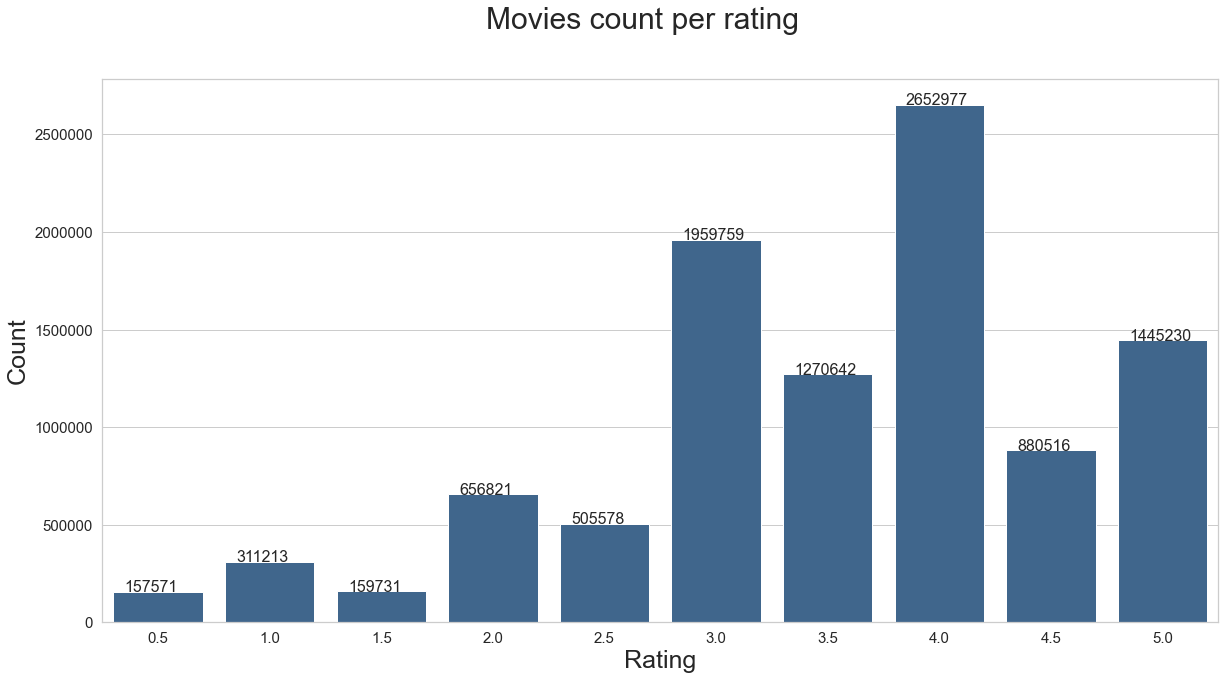

In [10]:
# Plotting the graph
fig, ax = plt.subplots(figsize=(20, 10)) # Initialize the plot with set figure size

# Create a countplot to visualise the number of movies per category
sns.countplot(ax=ax, x='rating', data=train_df, color=(0.2, 0.4, 0.6, 0.6)) 
plt.xlabel('Rating', fontsize=25)
plt.ylabel('Count', fontsize=25)
plt.xticks(size = 15)
plt.yticks(size = 15)
fig.suptitle("Movies count per rating", fontsize=30)
plt.ticklabel_format(style='plain', axis='y', useOffset=False) # Set the tick labels to appear in non-scientific form

# Make the counts appear on the different bars
for p in ax.patches:
    ax.annotate('{:.0f}'.format(p.get_height()), (p.get_x()+0.1, p.get_height()), size = 16)
    
# Show the countplot
plt.show()

Most movies where scored with a rating of 4 <br><br>
**Is there a correlation between how many times movies where rated and the rating?**

In [11]:
train_movies = train_df.merge(movies_df,on = 'movieId') # Merges the movie and train datasets
train_movies.drop(columns=['timestamp'],inplace=True) # Dropping the timestamp column
train_movies.head(10) # Shows the first 10 observations

,userId,movieId,rating,title,genres
0,5163,57669,4.0,In Bruges (2008),Comedy|Crime|Drama|Thriller
1,87388,57669,3.5,In Bruges (2008),Comedy|Crime|Drama|Thriller
2,137050,57669,4.0,In Bruges (2008),Comedy|Crime|Drama|Thriller
3,120490,57669,4.5,In Bruges (2008),Comedy|Crime|Drama|Thriller
4,50616,57669,4.5,In Bruges (2008),Comedy|Crime|Drama|Thriller
5,99887,57669,0.5,In Bruges (2008),Comedy|Crime|Drama|Thriller
6,120194,57669,4.5,In Bruges (2008),Comedy|Crime|Drama|Thriller
7,847,57669,3.5,In Bruges (2008),Comedy|Crime|Drama|Thriller
8,47201,57669,4.5,In Bruges (2008),Comedy|Crime|Drama|Thriller
9,94499,57669,4.5,In Bruges (2008),Comedy|Crime|Drama|Thriller


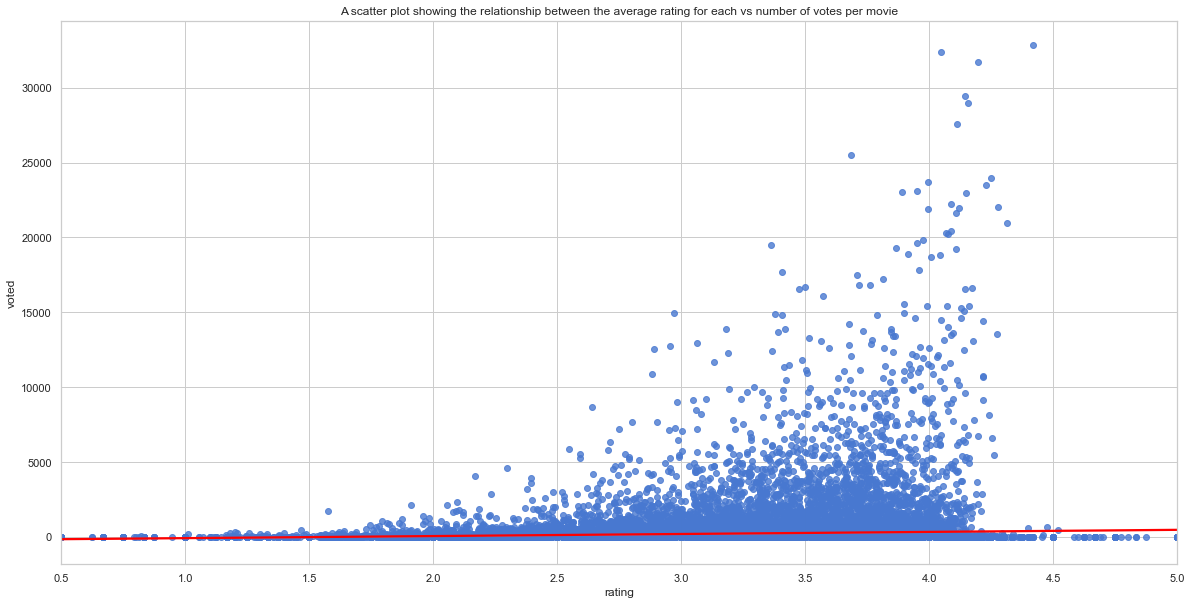

In [12]:
# Create a new dataframe from the train_movies dataframe to get the average rating  
train2 = train_movies.copy()

# Drop any duplicated information 
train2.drop_duplicates(['title','genres'],inplace = True)

# Get the  avarage rating for each movie in the data 
total_ratings = train_movies.groupby(['movieId','genres']).mean()['rating'].reset_index()

# Merge the the train2 and the total_ratings to create a new data 
train2 = train2.merge(total_ratings, on = 'movieId')

train2.drop(columns=['userId','rating_x','genres_y'],inplace=True) # Delete the duplicated columns

train2.rename(columns={'genres_x':'genres','rating_y':'rating'},inplace=True) # Rename the columns

train3 = train2.copy() # Make a copy of the Train2 dataset
# Create a user dataset to check how many time it has been voted for
user_rated = pd.DataFrame(train_df['movieId'].value_counts().reset_index()) # Create a user dataframe using groupby function

user_rated.rename(columns = {'index':'movieId','movieId':'voted'},inplace = True) # Rename the columns 

train3 = train3.merge(user_rated, on ='movieId') # Combine the train3 dataset with the User_rated data

# Create a dataframe to visualize the most rated movies and least rated movies
train4 = train3.sort_values('voted',ascending=False)

# Check for correlation between rating and number of the times have the user rated a movie

#Instantiate the figures
fig,ax = plt.subplots(figsize =(20,10))

# Create a scatter plot to visualise 
sns.regplot(data = train3, x = "rating", y = "voted",line_kws={"color": "red"})
ax.set_title("A scatter plot showing the relationship between the average rating for each vs number of votes per movie")
# Show the scatterplot
plt.show()

The more the users rated for a movie, the average rating of the movie seems to increase, similarly for movies that have the least movies which have a lower rating

### Users 

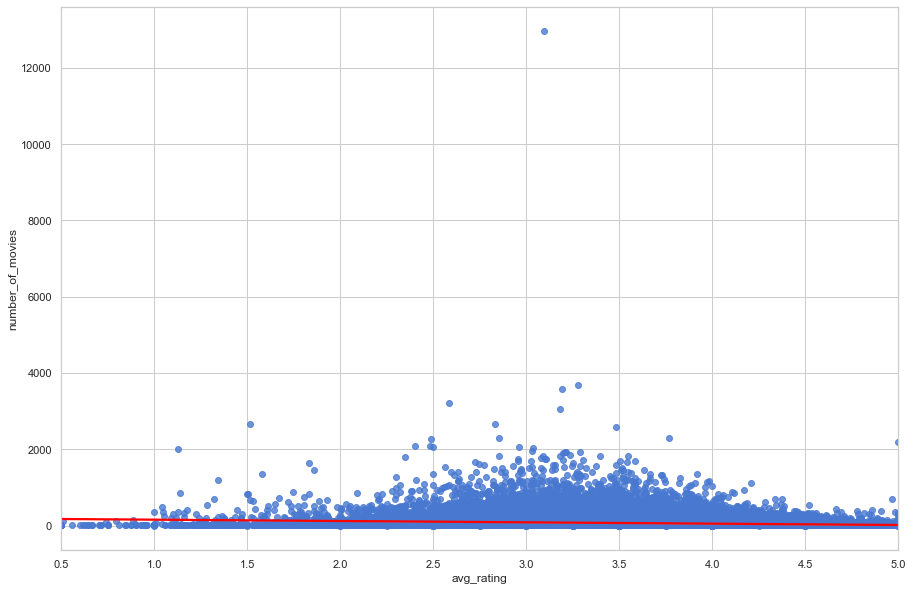

In [13]:
# Create a Dataframe consisting of the users average rating the give per user and number of times they have rated movies
train1 = pd.DataFrame(train_df.groupby('userId')['rating'].agg('mean').reset_index())
train1_2 = pd.DataFrame(train_df.groupby('userId')['rating'].count().reset_index())
# Merge the above to dataframe 
train1 = train1.merge(train1_2,on='userId',how = 'left')
# Rename the columns respectively
train1.rename(columns={'rating_x':'avg_rating','rating_y':'number_of_movies'},inplace = True)

# Sort the data in descending of the number of movies the user has rated
train1 = train1.sort_values('number_of_movies', ascending = False)

# Check for correlation between average rating and the number of the times have the user has watch a movie

# Create a scatter plot to visualise 
sns.regplot(data = train1, y = "number_of_movies", x = "avg_rating",line_kws={"color": "red"})

# Show the scatterplot
plt.show()

### Genres

['Adventure' 'Animation' 'Children' 'Comedy' 'Fantasy' 'Romance' 'Drama'
 'Action' 'Crime' 'Thriller' 'Horror' 'Mystery' 'Sci-Fi' 'IMAX'
 'Documentary' 'War' 'Musical' 'Western' 'Film-Noir' '(no genres listed)']


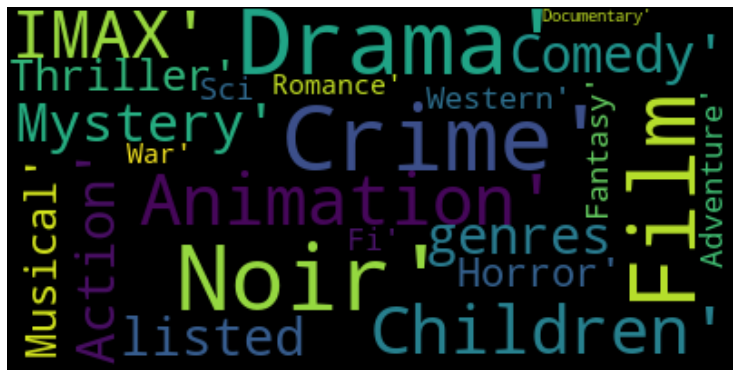

In [14]:
# Create dataframe containing only the movieId and genres
movies_genres = pd.DataFrame(movies_df[['movieId', 'genres']],
                             columns=['movieId', 'genres'])

# Split genres seperated by "|" and create a list containing the genres allocated to each movie
movies_genres.genres = movies_genres.genres.apply(lambda x: x.split('|'))

# Create expanded dataframe where each movie-genre combination is in a seperate row
movies_genres = pd.DataFrame([(tup.movieId, d) for tup in movies_genres.itertuples() for d in tup.genres],
                             columns=['movieId', 'genres'])

print(movies_genres['genres'].unique())

movies_genres.head()
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
gen = movies_genres['genres'].explode()
text = list(set(gen))
plt.rcParams['figure.figsize'] = (13, 13)
wordcloud = WordCloud(max_font_size=50, max_words=100,background_color="black").generate(str(text))

plt.imshow(wordcloud,interpolation="bilinear")
plt.axis("off")
plt.show()

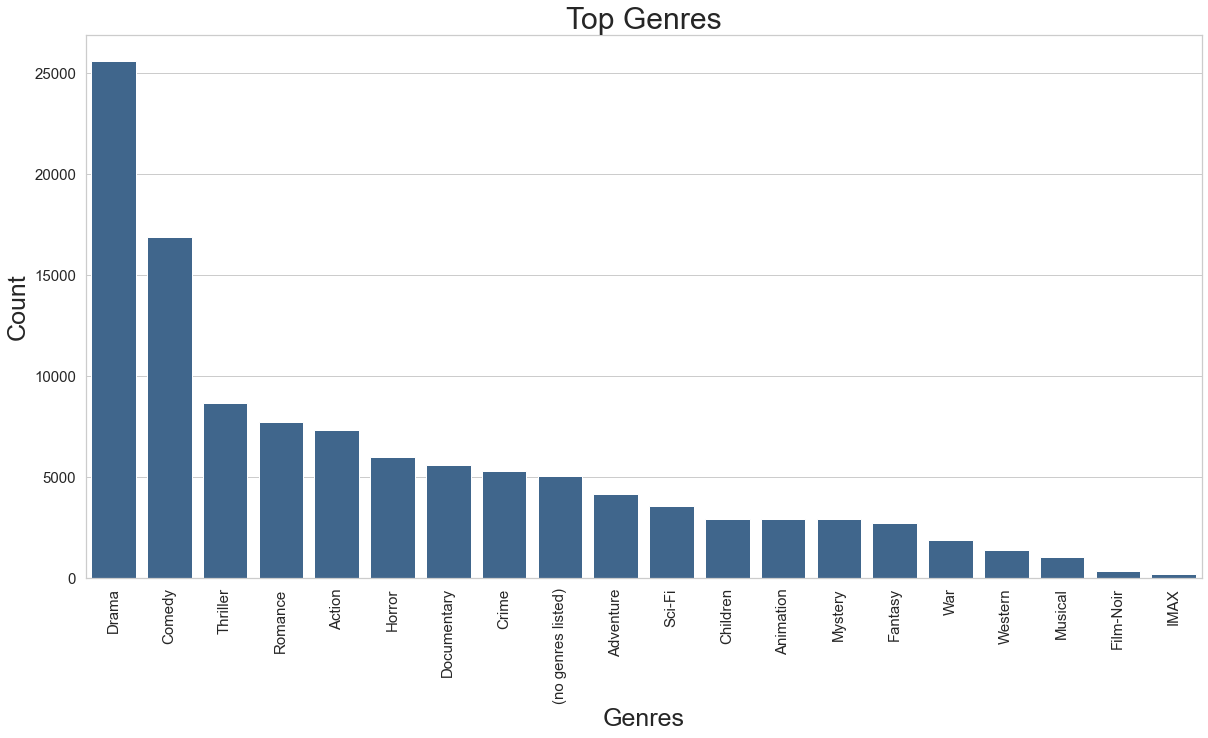

In [15]:
# Ploting top genres in the Dataset
plt.figure(figsize=(20, 10))
gen = movies_genres['genres'].explode()
ax=sns.countplot(x=gen, order=gen.value_counts().index[:30],color=(0.2, 0.4, 0.6, 0.6))
plt.xlabel('Genres', fontsize=25)
plt.ylabel('Count', fontsize=25)
plt.xticks(size = 15)
plt.yticks(size = 15)
ax.set_title('Top Genres', fontsize=30)
plt.xticks(rotation =90)
plt.show()

The top genres are Drama and Comedy. Movies however can have multiple genres 

## Data Engineering Post EDA 

In [16]:
# train_df = pd.read_csv('./train.csv')
# # remove outlier in userID in train_df
# display(train_df.info())
# display(train_df.head(3))

# train_df.drop(train_df.index[train_df['userId'] == 72315], inplace=True)

# train_df = train_df.reset_index(drop=True)

# display(train_df.info())

## 8. Recommendation System: Content Based Filtering

Content-based filtering uses item features to recommend other items similar to what the user likes, based on their previous actions or explicit feedback.

In [17]:
def data_preprocessing(subset_size):
    """Prepare data for use within Content filtering algorithm.

    Parameters
    ----------
    subset_size : int
        Number of movies to use within the algorithm.

    Returns
    -------
    Pandas Dataframe
        Subset of movies selected for content-based filtering.

    """
    movies = movies_df.copy()
    
    # Split the genres feature so that each genres will be in a list format 
    movies['genres'] = movies.genres.str.split('|')

    #Copying the movie dataframe into a new one since we won't need to use the genre information in our first case.
    moviesWithGenres_df = movies.copy()

    #For every row in the dataframe, iterate through the list of genres and place a 1 into the corresponding column
    for index, row in movies.iterrows():
        for genre in row['genres']:
            moviesWithGenres_df.at[index, genre] = 1
            
    #Filling in the NaN values with 0 to show that a movie doesn't have that column's genre
    moviesWithGenres_df = moviesWithGenres_df.fillna(0)
    moviesWithGenres_df.drop(['genres'],axis =1, inplace = True)
    
    # Slice the data
    movie_subset = moviesWithGenres_df[:subset_size]

    return movie_subset

In [18]:
def content_model(movie_list,top_n=10):
    """Performs Content filtering based upon a list of movies supplied
       by the app user.

    Parameters
    ----------
    movie_list : list (str)
        Favorite movies chosen by the app user.
    top_n : type
        Number of top recommendations to return to the user.

    Returns
    -------
    list (str)
        Titles of the top-n movie recommendations to the user.

    """
    # Initializing the empty list of recommended movies
    recommended_movies = []
    # Preprocess the data 
    data = data_preprocessing(27000)

    # Create a new DataFrame
    data2 = data.copy()

    # Change the index of the DataFrame
    data2 = data2.set_index('title')

    # Delete the columns the unneccesary columns 
    data.drop(['title'],axis = 1,inplace=True)
    
    # Generating the count matrix for each genres
    data = data.set_index('movieId')

    # Instantiating the model and fitting the model to the count matrix
    nn = NearestNeighbors(algorithm='brute',metric='cosine',n_neighbors=10)
    nn.fit(data)

    # Create an Empty list for the movieids
    movieids = []

    # Getting the movieids
    ind1 = data2.loc[movie_list[0],'movieId']
    ind2 = data2.loc[movie_list[1],'movieId']
    ind3 = data2.loc[movie_list[2],'movieId']

    # Adding the movieids to the list
    movieids.extend([ind1,ind2,ind3])
    # Setting a list of indexes
    index_list = []

    # Getting the suggestions in form of indexes
    for i in range(len(movieids)):
        distances,suggestions=nn.kneighbors(data.loc[movieids[i],:].values.reshape(1,-1),n_neighbors=15)

        for j in range(15):
            index_list.append(suggestions[0,j])

    # Creating an empty list to store the movie ids 
    movieids2 = []
    
    # Create a for loop get the titles of the movies
    for i in range(len(index_list)):
        id = data.index.values[index_list[i]]
        movieids2.append(id)

    # Create a list to store all the titles
    title_list = []

    # Create a new dataframe to get the titles of the movies and change the index to movieId 
    data3 = data_preprocessing(27000)
    data3 = data3.set_index('movieId')

    for i in range(len(movieids2)):
        title = data3.loc[movieids2[i],'title']
        if(title not in movie_list):
            title_list.append(title)

    # recommended movies 
    recommended_movies.extend(random.sample(title_list,k = top_n))
    return recommended_movies

Demo 

In [19]:
# Declare a movie list 
movielist = ["Toy Story (1995)","Jumanji (1995)","Grumpier Old Men (1995)"]

# Run the recommendation
recommendation = content_model(movielist,10)

print(recommendation)

['The Magic Crystal (2011)', 'Easy A (2010)', 'Chronicles of Narnia: The Lion, the Witch and the Wardrobe, The (2005)', 'Santa Claus: The Movie (1985)', 'Merrily We Live (1938)', 'Pelicanman (Pelikaanimies) (2004)', 'Turbo (2013)', "My Girlfriend's Boyfriend (2010)", 'Shrek the Third (2007)', 'Beautician and the Beast, The (1997)']


## 9. Dimensionality Reduction

### PCA

In [20]:
# Scaling the movies_df
# declare the features to be all columns from our movies_df
features = [col for col in train_df.columns]

# create scaler object
scaler = StandardScaler()

# define scaled data frame variable
scaled_df = pd.read_csv('train.csv') # <---- changed after feature engineering - userID 72315 omitted 
#scaled_df = train_df

scaled_df[features] = preprocessing.scale(scaled_df[features])

Text(0, 0.5, 'Cumulative explained variance')

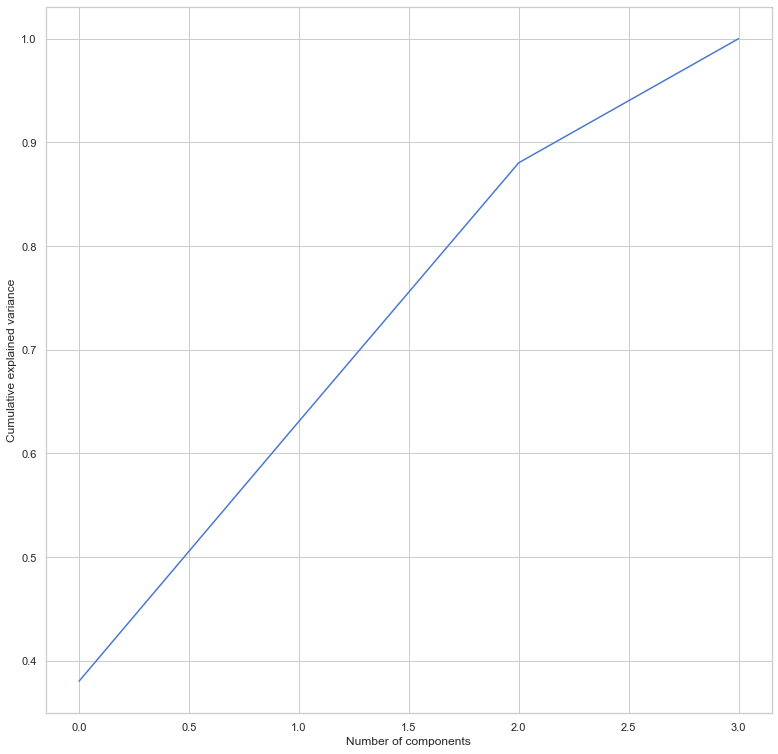

In [21]:
# define PCA object
pca = PCA()

# fit the PCA model to our data and apply the dimensionality reduction 
prin_comp = pca.fit_transform(scaled_df[features])

# create a dataframe containing the principal components
pca_df = pd.DataFrame(data = prin_comp)



# plot line graph of cumulative variance explained
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of components')
plt.ylabel('Cumulative explained variance')

In [22]:
pca_85 = PCA(.85)
pca_85.fit_transform(scaled_df[features])
print(round(pca_85.explained_variance_ratio_.sum()*100, 1),
      "% of variance explained by",
      pca_85.n_components_,
      "components.")

88.0 % of variance explained by 3 components.


In [23]:
pca.explained_variance_ratio_[:3]

array([0.3802045 , 0.25060905, 0.24947369])

In this instance, the first component explains 38%, with the 2nd following behind at 25% and the 3rd at 25% as well. Together, these components explain 88% of the data.

**Putting Our Dimensionality Reduction to Use**

Lets build a predictive regressor model.

We will use the feature named `Rating` as the response variable (the one that we will try to predict). This feature was used in our initial PCA, so we will have to make some changes to the dataset to ensure it is not included this time.

PCA requires features to be scaled, as we mentioned above. But we don't need to scale the response variable which we will use for prediction, as it is not used in PCA. This is good, because leaving the response as is means any predicted values and associated errors are easier to interpret. 

In [24]:
# exclude non-features from data
reg_data = scaled_df[features]

# set aside response variable (Unscaled!)
reg_response = train_df["rating"]

# drop response variable
reg_data = reg_data.drop(['rating'], 1)

Now, let's split the dataset up into train and test using with a ration of 80 percent training data and 20 percent testing data.

In [25]:
X_train, X_test, y_train, y_test = train_test_split(reg_data, reg_response, test_size=0.2)

Next, we apply PCA to the training set with the number of components set to 2.

In [26]:
# create PCA object with n_components set to 2
pca_reg = PCA(n_components=2)

# fit the PCA model to our data and apply the dimensionality reduction 
X_train = pca_reg.fit_transform(X_train)

# confirm the number of components
pca_reg.n_components_

2

In [27]:
pca_reg.explained_variance_ratio_.sum()

0.8402896522217365

## 10. Collaborative Filtering

In our modelling we're going to use the surprise package. Surprise is a Python scikit for building and analyzing recommender systems that deal with explici rating data. The name SurPRISE stands for Simple Python RecommendatIon System Engine.

Surprise allows us to use a built-in datasets, **Movielens**. We'll use this data to run experiments on with different models before we decide on a model and use it on our own data. 

The MovieLends dataset is with a smaller dataset than ours, making it easy to implement new algorithm ideas. 

We'll use the Train-test split and the fit() method to get the RMSE for each algorithm

### Model 1 - Surprise MovieLens run with Singular value decomposition - SVD 


Singular value decomposition (SVD) is a matrix factorization method that generalizes the eigendecomposition of a square matrix (n x n) to any matrix (n x m)

SVD is similar to Principal Component Analysis (PCA), but more general.


In [58]:
from surprise import SVD
from surprise import Dataset
from surprise import accuracy
from surprise.model_selection import train_test_split

# Load the movielens-100k dataset (download it if needed),
data = Dataset.load_builtin('ml-100k')

# sample random trainset and testset
# test set is made of 25% of the ratings.
trainset, testset = train_test_split(data, test_size=.25)

# We'll use the SVD algorithm.
algo = SVD()

# Train the algorithm on the trainset, and predict ratings for the testset
algo.fit(trainset)
predictions = algo.test(testset)

# Then compute RMSE
SVD_RMSE = accuracy.rmse(predictions)
print('SVD_RMSE = ' + str(SVD_RMSE))

RMSE: 0.9467
SVD_RMSE = 0.9466639650354307


### Model 2 - Surprise MovieLens run with SVD++

The SVD++ algorithm, an extension of SVD taking into account implicit ratings.

In [59]:
from surprise import SVDpp

# sample random trainset and testset
# test set is made of 25% of the ratings.
trainset, testset = train_test_split(data, test_size=.25)

# We'll use the SVD++ algorithm here
algo = SVDpp()

# Train the algorithm on the trainset, and predict ratings for the testset
algo.fit(trainset)
predictions = algo.test(testset)

# Then compute RMSE
SVDpp_RMSE = accuracy.rmse(predictions)
print('SVDpp_RMSE = ' + str(SVDpp_RMSE))

RMSE: 0.9221
SVDpp_RMSE = 0.9221447757478419


### Model 3 - Surprise MovieLens run with Non-negative matrix factorization - NMF
Non-negative matrix factorization, also non-negative matrix approximation is a group of algorithms in multivariate analysis and linear algebra where a matrix V is factorized into two matrices W and H, with the property that all three matrices have no negative elements.

In [69]:
from surprise import NMF

# sample random trainset and testset
# test set is made of 25% of the ratings.
trainset, testset = train_test_split(data, test_size=.25)

# We'll use the SVD++ algorithm here
algo = NMF()

# Train the algorithm on the trainset, and predict ratings for the testset
algo.fit(trainset)
predictions = algo.test(testset)

# Then compute RMSE
NMF_RMSE = accuracy.rmse(predictions)
print('NMF_RMSE = ' + str(NMF_RMSE))

RMSE: 0.9657
NMF_RMSE = 0.9657002345238624


### Model 4 - Surprise MovieLens run with Slope One

Slope One is a family of algorithms used for collaborative filtering, introduced in a 2005 paper by Daniel Lemire and Anna Maclachlan. Arguably, it is the simplest form of non-trivial item-based collaborative filtering based on ratings. Their simplicity makes it especially easy to implement them efficiently while their accuracy is often on par with more complicated and computationally expensive algorithms

In [64]:
from surprise import SlopeOne

# sample random trainset and testset
# test set is made of 25% of the ratings.
trainset, testset = train_test_split(data, test_size=.25)

# We'll use the SVD++ algorithm here
algo = SlopeOne()

# Train the algorithm on the trainset, and predict ratings for the testset
algo.fit(trainset)
predictions = algo.test(testset)

# Then compute RMSE
SlopeOne_RMSE = accuracy.rmse(predictions)
print('SlopeOne_RMSE = ' + str(SlopeOne_RMSE))

RMSE: 0.9458
SlopeOne_RMSE = 0.9458169015249022


### Model 5 - Surprise MovieLens run with k-NN

In [65]:
from surprise import KNNBasic

# sample random trainset and testset
# test set is made of 25% of the ratings.
trainset, testset = train_test_split(data, test_size=.25)

# We'll use the SVD++ algorithm here
algo = KNNBasic()

# Train the algorithm on the trainset, and predict ratings for the testset
algo.fit(trainset)
predictions = algo.test(testset)

# Then compute RMSE
KNN_RMSE = accuracy.rmse(predictions)
print('KNN_RMSE = ' + str(KNN_RMSE))

Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 0.9912
KNN_RMSE = 0.9911610213704242


Lets graph the RMSE results for each algorith experiment. 

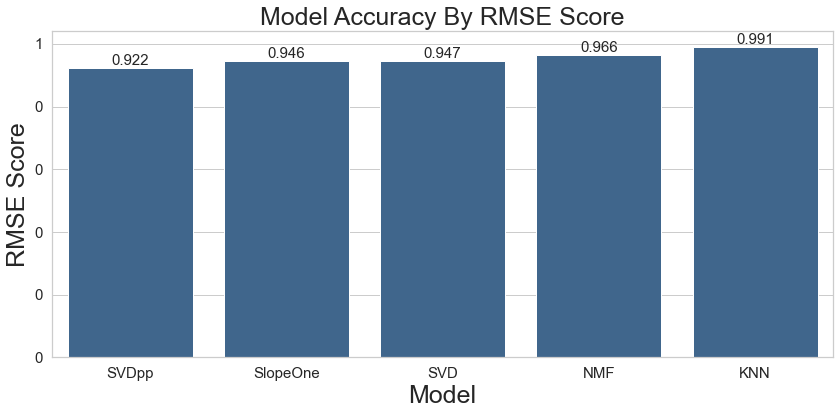

In [82]:
rmse_scores =[SVD_RMSE,SVDpp_RMSE,NMF_RMSE,SlopeOne_RMSE,KNN_RMSE]
models =['SVD','SVDpp','NMF','SlopeOne','KNN']

accuracy_data = pd.DataFrame({'model':models,'RMSE':rmse_scores})

fig, ax = plt.subplots(figsize=(14,6))
sns.barplot(data=accuracy_data.sort_values(by='RMSE'), x='model', y='RMSE', color=(0.2, 0.4, 0.6, 0.6), ax=ax)
ax.set_xlabel("Model", size=25)
ax.set_ylabel('RMSE Score', size=25)
ax.set_yticklabels(['{:,}'.format(int(x)) for x in ax.get_yticks().tolist()])
plt.xticks(size = 15)
plt.yticks(size = 15)
for p in ax.patches:
    ax.text(p.get_x() + p.get_width()/2, p.get_y() + p.get_height(), round(p.get_height(),3), fontsize=15, ha="center", va='bottom')
plt.title('Model Accuracy By RMSE Score', fontsize=25)
plt.show()

The SVDpp gives us the lowest RSME. We'll use that algorithm on our own data. 

### Apply to our own data

We require a Reader object, but only the rating_scale parameter must be specified. The dataframe must have three columns, corresponding to the user (raw) ids, the item (raw) ids, and the ratings in this order (which we will specify below). Each row thus corresponds to a given rating.

In [84]:
train_df = pd.read_csv('train.csv')

In [86]:
# from surprise import SVD
# from surprise import Dataset
# from surprise.model_selection import cross_validate

#our training data
df = pd.DataFrame(train_df)
del df['timestamp']


# A reader is still needed but only the rating_scale param is requiered.
reader = Reader(rating_scale=(0, 5))

# The columns must correspond to user id, item id and ratings (in that order).
data = Dataset.load_from_df(df[['userId', 'movieId', 'rating']], reader)

Train the algorithm after having prepared the dataset

In [ ]:
#packages we need
from surprise import accuracy
from surprise.model_selection import train_test_split

#allows us to train on the whole dataset
trainset = data.build_full_trainset()

#SVD++ algorithm.
algo = SVDpp()

# Train the algorithm on the trainset, and predict ratings for the testset
algo.fit(trainset)

Train/test split and see what the RMSE metric is, before we determine the ratings of the users in the test set with our model trained on all the data

In [ ]:
# sample random trainset and testset
# test set is made of 25% of the ratings.
trainset, testset = train_test_split(data, test_size=.25)

# Use the SVD++ algorithm.
algo2 = SVDpp()

# Train the algorithm on the trainset, and predict ratings for the testset
algo2.fit(trainset)
predictions = algo2.test(testset)

# Compute RMSE
accuracy.rmse(predictions)

## 11. Conclusion

In [33]:
# End Comet Experiment 
experiment.end()

COMET INFO: ---------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.ml/drikus-d/recommender/40e985232a4d4685881874c7e70184cd
COMET INFO:   Parameters:
COMET INFO:     algorithm     : brute
COMET INFO:     leaf_size     : 30
COMET INFO:     metric        : cosine
COMET INFO:     metric_params : 1
COMET INFO:     n_jobs        : 1
COMET INFO:     n_neighbors   : 10
COMET INFO:     p             : 2
COMET INFO:     radius        : 1.0
COMET INFO:   Uploads:
COMET INFO:     environment details      : 1
COMET INFO:     filename                 : 1
COMET INFO:     git metadata             : 1
COMET INFO:     git-patch (uncompressed) : 1 (754.33 KB)
COMET INFO:     installed packages       : 1
COMET INFO:     notebook                 : 1
COMET INFO:     source_code              : 1
COMET INFO: ---------------------------
CO

## 12. Submission

Prep our test dataframe for the the surprise package, as it requires User, Item and a rating column

In [34]:
test_df = pd.read_csv('test.csv')

test_df.loc[:, 'rating'] = 0


#using load_from_df surprise function to load dataset for predictions
test_processed = Dataset.load_from_df(test_df[['userId','movieId','rating']], reader)

#Train test split, test size will be equal to 1.
NA, test = train_test_split(test_processed, test_size=1.0, shuffle = False, random_state = 42)

#Prediction 
predictions = algo.test(test)

#saving the predictions as a list to add as a column for our Kaggle submission
ratings = [i.est for i in predictions]
ratings

[3.6439865337461206,
 4.202832424980215,
 3.711730049893246,
 3.8329502575349923,
 2.4375272351876243,
 3.8651558590282606,
 3.765176111808063,
 3.3677671294449563,
 3.938031818672169,
 3.439964836374906,
 3.0367935180875802,
 3.074158819862891,
 3.9077291222099997,
 4.553100657841355,
 4.061155976300166,
 4.1572373023996985,
 3.483813812074315,
 3.0720639532150242,
 3.3421925151141028,
 3.520572964725068,
 3.9091300832294507,
 2.8866138053704935,
 3.2859419088988577,
 2.903516680701049,
 3.849042904135788,
 3.4616127905338883,
 3.803885195660845,
 3.3088292064760125,
 3.6887904499193964,
 3.5533287472088415,
 3.7990944530618935,
 3.4639279394351705,
 3.1894711666276208,
 3.23336440259803,
 2.9436459538422333,
 3.2762701206373435,
 3.586235622353442,
 3.75008834034665,
 5,
 3.0400481423721697,
 3.711968992048403,
 3.6896860144769743,
 3.9713893666766404,
 3.58582806772196,
 4.464657717603845,
 3.4453715189109744,
 4.02359106443454,
 4.67830815697265,
 3.8818807084626603,
 4.49173844713

Create a new dataframe with the ratings included and combining the userId and movieId into one column.

In [35]:
display(sample_submission_df.head())
test_df['Id'] = test_df['userId'].astype(str)  + '_'+ test_df['movieId'].astype(str) 
test_df
#change rating column
test_df['rating'] = ratings
del test_df['userId']
del test_df['movieId']
display(test_df)

,Id,rating
0,1_2011,1.0
1,1_4144,1.0
2,1_5767,1.0
3,1_6711,1.0
4,1_7318,1.0


,rating,Id
0,3.643987,1_2011
1,4.202832,1_4144
2,3.711730,1_5767
3,3.832950,1_6711
4,2.437527,1_7318
...,...,...
5000014,3.721783,162541_4079
5000015,3.774999,162541_4467
5000016,2.874256,162541_4980
5000017,3.033004,162541_5689


In [36]:
test_df['R'] = test_df['rating']
del test_df['rating']
test_df['rating'] = test_df['R']
del test_df['R']
test_df

,Id,rating
0,1_2011,3.643987
1,1_4144,4.202832
2,1_5767,3.711730
3,1_6711,3.832950
4,1_7318,2.437527
...,...,...
5000014,162541_4079,3.721783
5000015,162541_4467,3.774999
5000016,162541_4980,2.874256
5000017,162541_5689,3.033004


In [37]:
test_df.to_csv('Kaggle_submission.csv', index = False)